# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

from nltk.stem.snowball import SnowballStemmer
from gensim.parsing.preprocessing import remove_stopwords

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import math
import string

# Load the data

In [2]:
movies_path = 'D:/Ria/Mtech/Semester_4/proj/DATASETS/MOVIE LENS/movie.csv'
ratings_path = 'D:/Ria/Mtech/Semester_4/proj/DATASETS/MOVIE LENS/rating.csv'
tmdb_path = 'D:/Ria/Mtech/Semester_4/proj/DATASETS/TMDB/tmdb_movies_data.csv'
link_path = 'D:/Ria/Mtech/Semester_4/proj/DATASETS/MOVIE LENS/link.csv'

In [3]:
movies = pd.read_csv(movies_path)
ratings = pd.read_csv(ratings_path)
tmdb = pd.read_csv(tmdb_path)
link = pd.read_csv(link_path)

# Explanatory Data Analysis

## Explore the data

In [4]:
# List of the features within the dataset
print("Movies : ", movies.columns,end="\n\n")
print("Ratings : ", ratings.columns,end="\n\n")
print("Link : ", link.columns,end="\n\n")
print("TMDB : ", tmdb.columns,end="\n\n")

Movies :  Index(['movieId', 'title', 'genres'], dtype='object')

Ratings :  Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

Link :  Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')

TMDB :  Index(['id', 'imdb_id', 'popularity', 'budget', 'revenue', 'original_title',
       'cast', 'homepage', 'director', 'tagline', 'keywords', 'overview',
       'runtime', 'genres', 'production_companies', 'release_date',
       'vote_count', 'vote_average', 'release_year', 'budget_adj',
       'revenue_adj'],
      dtype='object')



In [5]:
# Check the number of rows and columns in the movies data
print(movies.shape)

# Check the data types of each column in the movies data
print(movies.info())

(27278, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB
None


In [6]:
# Check for null values
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [7]:
for df in [movies, ratings,tmdb]:
    
    # Check the number of rows and columns in the ratings data
    print('Shape:', df.shape)

    # Check the data types of each column in the ratings data
    print('Info:', df.info())

    # Check the summary statistics of the ratings data
    print('Describe: ', df.describe())
    
    # Check for null values
    print('Null values:', df.isnull().sum())

    # Check for duplicated values
    print('Duplicated values:',df.duplicated().sum())
    
    # Display the first few rows of the data
    print('First few rows:', df.head())
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

Shape: (27278, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB
Info: None
Describe:               movieId
count   27278.000000
mean    59855.480570
std     44429.314697
min         1.000000
25%      6931.250000
50%     68068.000000
75%    100293.250000
max    131262.000000
Null values: movieId    0
title      0
genres     0
dtype: int64
Duplicated values: 0
First few rows:    movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                       

In [8]:
#Preprocessing

In [9]:
tmdb.drop(columns=['original_title','imdb_id','homepage','budget','revenue','runtime','vote_count','vote_average', 'budget_adj', 'revenue_adj'],inplace=True)
tmdb.columns

Index(['id', 'popularity', 'cast', 'director', 'tagline', 'keywords',
       'overview', 'genres', 'production_companies', 'release_date',
       'release_year'],
      dtype='object')

In [10]:
movies = movies.drop(['genres'], axis=1, inplace=False)
movies.columns

Index(['movieId', 'title'], dtype='object')

In [11]:
movies = movies.merge(link, on = "movieId")
movies = movies.merge(tmdb, left_on='tmdbId', right_on='id')
movies.head()

,movieId,title,imdbId,tmdbId,id,popularity,cast,director,tagline,keywords,overview,genres,production_companies,release_date,release_year
0,1,Toy Story (1995),114709,862.0,862,4.282462,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,The adventure takes off!,jealousy|toy|boy|friendship|friends,Woody the cowboy is young Andyâ€™s favorite to...,Animation|Comedy|Family,Walt Disney Pictures|Pixar Animation Studios,10/30/1995,1995
1,2,Jumanji (1995),113497,8844.0,8844,2.245837,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Joe Johnston,Roll the dice and unleash the excitement!,board game|disappearance|based on a children's...,When siblings Judy and Peter discover an encha...,Adventure|Fantasy|Family,TriStar Pictures|Teitler Film|Interscope Commu...,12/15/1995,1995
2,3,Grumpier Old Men (1995),113228,15602.0,15602,0.605081,Walter Matthau|Jack Lemmon|Ann-Margret|Sophia ...,Howard Deutch,Still Yelling. Still Fighting. Still Ready for...,fishing|best friend|duringcreditsstinger|old men,A family wedding reignites the ancient feud be...,Romance|Comedy,Warner Bros.|Lancaster Gate,12/22/1995,1995
3,4,Waiting to Exhale (1995),114885,31357.0,31357,0.200906,Whitney Houston|Angela Bassett|Loretta Devine|...,Forest Whitaker,Friends are the people who let you be yourself...,based on novel|interracial relationship|single...,"Cheated on, mistreated and stepped on, the wom...",Comedy|Drama|Romance,Twentieth Century Fox Film Corporation,12/22/1995,1995
4,5,Father of the Bride Part II (1995),113041,11862.0,11862,0.758379,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Charles Shyer,Just When His World Is Back To Normal... He's ...,baby|midlife crisis|confidence|aging|daughter,Just when George Banks has recovered from his ...,Comedy,Sandollar Productions|Touchstone Pictures,12/8/1995,1995


In [12]:
movies.columns

Index(['movieId', 'title', 'imdbId', 'tmdbId', 'id', 'popularity', 'cast',
       'director', 'tagline', 'keywords', 'overview', 'genres',
       'production_companies', 'release_date', 'release_year'],
      dtype='object')

In [13]:
ratings = ratings.merge(link, on = "movieId")
ratings = ratings.merge(movies, on='movieId')
ratings.head()

,userId,movieId,rating,timestamp,imdbId_x,tmdbId_x,title,imdbId_y,tmdbId_y,id,popularity,cast,director,tagline,keywords,overview,genres,production_companies,release_date,release_year
0,1,2,3.5,2005-04-02 23:53:47,113497,8844.0,Jumanji (1995),113497,8844.0,8844,2.245837,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Joe Johnston,Roll the dice and unleash the excitement!,board game|disappearance|based on a children's...,When siblings Judy and Peter discover an encha...,Adventure|Fantasy|Family,TriStar Pictures|Teitler Film|Interscope Commu...,12/15/1995,1995
1,5,2,3.0,1996-12-25 15:26:09,113497,8844.0,Jumanji (1995),113497,8844.0,8844,2.245837,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Joe Johnston,Roll the dice and unleash the excitement!,board game|disappearance|based on a children's...,When siblings Judy and Peter discover an encha...,Adventure|Fantasy|Family,TriStar Pictures|Teitler Film|Interscope Commu...,12/15/1995,1995
2,13,2,3.0,1996-11-27 08:19:02,113497,8844.0,Jumanji (1995),113497,8844.0,8844,2.245837,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Joe Johnston,Roll the dice and unleash the excitement!,board game|disappearance|based on a children's...,When siblings Judy and Peter discover an encha...,Adventure|Fantasy|Family,TriStar Pictures|Teitler Film|Interscope Commu...,12/15/1995,1995
3,29,2,3.0,1996-06-23 20:36:14,113497,8844.0,Jumanji (1995),113497,8844.0,8844,2.245837,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Joe Johnston,Roll the dice and unleash the excitement!,board game|disappearance|based on a children's...,When siblings Judy and Peter discover an encha...,Adventure|Fantasy|Family,TriStar Pictures|Teitler Film|Interscope Commu...,12/15/1995,1995
4,34,2,3.0,1996-10-28 13:29:44,113497,8844.0,Jumanji (1995),113497,8844.0,8844,2.245837,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Joe Johnston,Roll the dice and unleash the excitement!,board game|disappearance|based on a children's...,When siblings Judy and Peter discover an encha...,Adventure|Fantasy|Family,TriStar Pictures|Teitler Film|Interscope Commu...,12/15/1995,1995


In [14]:
ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'imdbId_x', 'tmdbId_x',
       'title', 'imdbId_y', 'tmdbId_y', 'id', 'popularity', 'cast', 'director',
       'tagline', 'keywords', 'overview', 'genres', 'production_companies',
       'release_date', 'release_year'],
      dtype='object')

In [15]:
movies.shape

(9055, 15)

In [16]:
ratings.shape

(17533255, 20)

In [17]:
# Extract genres 

# Split the "genres" column into multiple columns using get_dummies()
genres_df = movies['genres'].str.get_dummies('|')
print('These are the available genres:\n',genres_df.columns.values)

These are the available genres:
 ['Action' 'Adventure' 'Animation' 'Comedy' 'Crime' 'Documentary' 'Drama'
 'Family' 'Fantasy' 'Foreign' 'History' 'Horror' 'Music' 'Mystery'
 'Romance' 'Science Fiction' 'TV Movie' 'Thriller' 'War' 'Western']


In [18]:
genres_df

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9050,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9051,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
9052,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
9053,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


## Visualize the data

In [19]:
# Compute the sum of each column to get the number of movies per genre
movies_per_genre = genres_df.sum()

# Print the result
print(movies_per_genre)

Action             2070
Adventure          1256
Animation           487
Comedy             3259
Crime              1256
Documentary         395
Drama              4165
Family              949
Fantasy             768
Foreign             142
History             299
Horror             1289
Music               327
Mystery             715
Romance            1519
Science Fiction    1009
TV Movie             68
Thriller           2520
War                 246
Western             149
dtype: int64


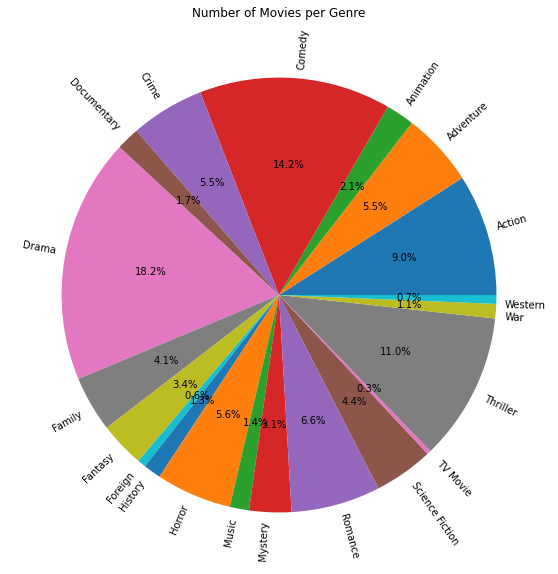

In [20]:
# Plot the % of movies by genre

plt.figure(figsize=(50, 10))
plt.pie(movies_per_genre, labels=movies_per_genre.index, autopct='%.1f%%', labeldistance=1.04, rotatelabels=True)

plt.title('Number of Movies per Genre')
plt.show()

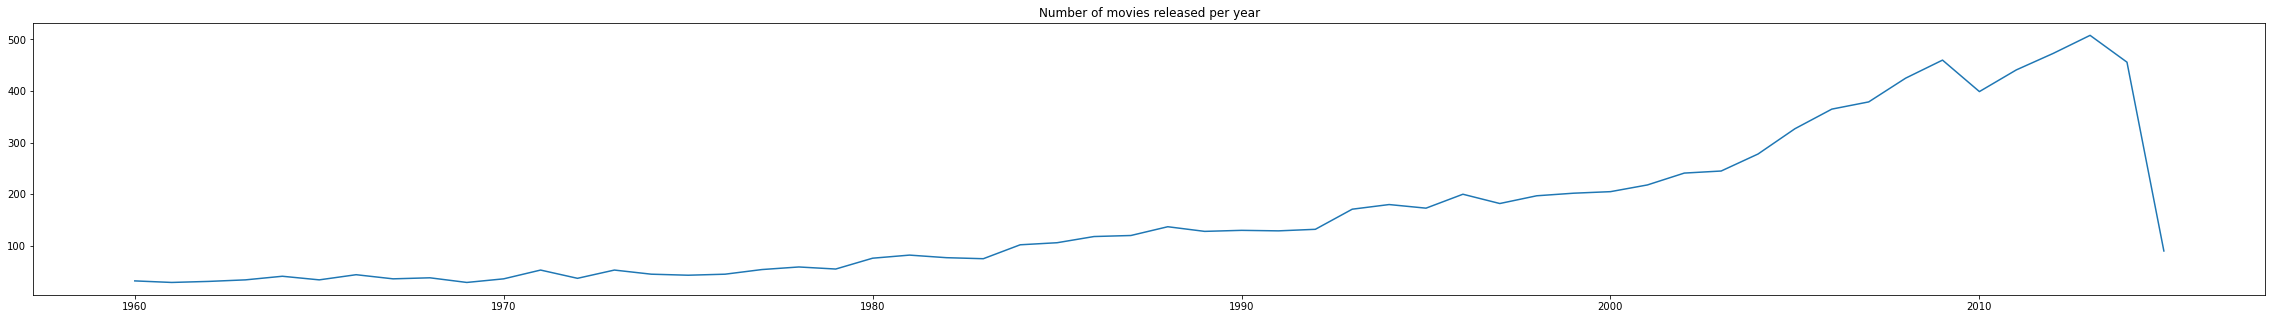

Max No.of Movies Relesed = 508
Year = 2013


In [21]:
# Plot the # of movies released each year

plt.figure(figsize=(40, 5))
plt.plot(movies.groupby('release_year').title.count())
plt.title('Number of movies released per year')
plt.show()
a=movies.groupby('release_year').title.count()
print('Max No.of Movies Relesed =',a.max())
for i in a.index:
    if a[i] == a.max():
        print('Year =',i)

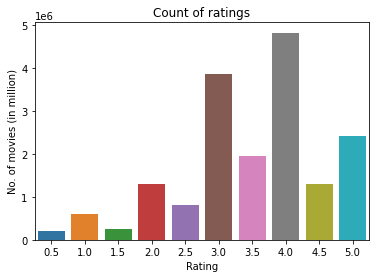

In [22]:
# Plot a histogram of the ratings data
sns.countplot(data=ratings, x='rating')
plt.title('Count of ratings')
plt.xlabel('Rating')
plt.ylabel('No. of movies (in million)')
plt.show()

# Data preparation


In [23]:
movies.head()

,movieId,title,imdbId,tmdbId,id,popularity,cast,director,tagline,keywords,overview,genres,production_companies,release_date,release_year
0,1,Toy Story (1995),114709,862.0,862,4.282462,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,The adventure takes off!,jealousy|toy|boy|friendship|friends,Woody the cowboy is young Andyâ€™s favorite to...,Animation|Comedy|Family,Walt Disney Pictures|Pixar Animation Studios,10/30/1995,1995
1,2,Jumanji (1995),113497,8844.0,8844,2.245837,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Joe Johnston,Roll the dice and unleash the excitement!,board game|disappearance|based on a children's...,When siblings Judy and Peter discover an encha...,Adventure|Fantasy|Family,TriStar Pictures|Teitler Film|Interscope Commu...,12/15/1995,1995
2,3,Grumpier Old Men (1995),113228,15602.0,15602,0.605081,Walter Matthau|Jack Lemmon|Ann-Margret|Sophia ...,Howard Deutch,Still Yelling. Still Fighting. Still Ready for...,fishing|best friend|duringcreditsstinger|old men,A family wedding reignites the ancient feud be...,Romance|Comedy,Warner Bros.|Lancaster Gate,12/22/1995,1995
3,4,Waiting to Exhale (1995),114885,31357.0,31357,0.200906,Whitney Houston|Angela Bassett|Loretta Devine|...,Forest Whitaker,Friends are the people who let you be yourself...,based on novel|interracial relationship|single...,"Cheated on, mistreated and stepped on, the wom...",Comedy|Drama|Romance,Twentieth Century Fox Film Corporation,12/22/1995,1995
4,5,Father of the Bride Part II (1995),113041,11862.0,11862,0.758379,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Charles Shyer,Just When His World Is Back To Normal... He's ...,baby|midlife crisis|confidence|aging|daughter,Just when George Banks has recovered from his ...,Comedy,Sandollar Productions|Touchstone Pictures,12/8/1995,1995


In [24]:
ratings.drop(['timestamp'], axis=1, inplace= True)

In [25]:
ratings

,userId,movieId,rating,imdbId_x,tmdbId_x,title,imdbId_y,tmdbId_y,id,popularity,cast,director,tagline,keywords,overview,genres,production_companies,release_date,release_year
0,1,2,3.5,113497,8844.0,Jumanji (1995),113497,8844.0,8844,2.245837,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Joe Johnston,Roll the dice and unleash the excitement!,board game|disappearance|based on a children's...,When siblings Judy and Peter discover an encha...,Adventure|Fantasy|Family,TriStar Pictures|Teitler Film|Interscope Commu...,12/15/1995,1995
1,5,2,3.0,113497,8844.0,Jumanji (1995),113497,8844.0,8844,2.245837,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Joe Johnston,Roll the dice and unleash the excitement!,board game|disappearance|based on a children's...,When siblings Judy and Peter discover an encha...,Adventure|Fantasy|Family,TriStar Pictures|Teitler Film|Interscope Commu...,12/15/1995,1995
2,13,2,3.0,113497,8844.0,Jumanji (1995),113497,8844.0,8844,2.245837,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Joe Johnston,Roll the dice and unleash the excitement!,board game|disappearance|based on a children's...,When siblings Judy and Peter discover an encha...,Adventure|Fantasy|Family,TriStar Pictures|Teitler Film|Interscope Commu...,12/15/1995,1995
3,29,2,3.0,113497,8844.0,Jumanji (1995),113497,8844.0,8844,2.245837,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Joe Johnston,Roll the dice and unleash the excitement!,board game|disappearance|based on a children's...,When siblings Judy and Peter discover an encha...,Adventure|Fantasy|Family,TriStar Pictures|Teitler Film|Interscope Commu...,12/15/1995,1995
4,34,2,3.0,113497,8844.0,Jumanji (1995),113497,8844.0,8844,2.245837,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Joe Johnston,Roll the dice and unleash the excitement!,board game|disappearance|based on a children's...,When siblings Judy and Peter discover an encha...,Adventure|Fantasy|Family,TriStar Pictures|Teitler Film|Interscope Commu...,12/15/1995,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17533250,131904,111944,2.0,1425922,175541.0,Black Nativity (2013),1425922,175541.0,175541,0.442256,Forest Whitaker|Angela Bassett|Jennifer Hudson...,Kasi Lemmons,The Musical Event of the Holiday Season,based on novel|musical|color in title|based on...,A street-wise teen from Baltimore who has been...,Drama|Music,Fox Searchlight Pictures|Fox Searchlight,11/27/2013,2013
17533251,131965,119314,2.0,1065106,18755.0,Pigs (2007),1065106,18755.0,18755,0.258705,Jefferson Brown|Darryn Lucio|Christopher Ellio...,Karl DiPelino,26 girls. 26 letters in the alphabet. 1 campus...,brotherhood,A college ladies man accepts a challenge from ...,Comedy,Bad Monkey Productions|Hill's Production Services,11/5/2007,2007
17533252,133047,130524,4.5,2272918,261375.0,Flying Home (2014),2272918,261375.0,261375,0.445011,Jamie Dornan|Charlotte De Bruyne|Jan Decleir|A...,Dominique Deruddere,NaN,grandfather|betrayal|pigeon,"Colin, an ambitious young American businessman...",Romance,Kanakna Productions|Otomatic|Twenty Four 9 Films,4/2/2014,2014
17533253,137031,123188,2.5,2404583,258251.0,Ironclad 2: Battle for Blood (2014),2404583,258251.0,258251,0.169396,Michelle Fairley|Roxanne McKee|Rosie Day|Danny...,Jonathan English,NaN,sword fight|medieval,A survivor of the Great Siege of Rochester Cas...,Action|Adventure,Mythic International Entertainment|Gloucester ...,3/14/2014,2014


In [26]:
# Merge with genres
movie_features = pd.merge(movies, genres_df, left_index=True, right_index=True)

In [27]:
movie_features.columns

Index(['movieId', 'title', 'imdbId', 'tmdbId', 'id', 'popularity', 'cast',
       'director', 'tagline', 'keywords', 'overview', 'genres',
       'production_companies', 'release_date', 'release_year', 'Action',
       'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery',
       'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western'],
      dtype='object')

In [28]:
movie_features.head()

,movieId,title,imdbId,tmdbId,id,popularity,cast,director,tagline,keywords,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,1,Toy Story (1995),114709,862.0,862,4.282462,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,The adventure takes off!,jealousy|toy|boy|friendship|friends,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),113497,8844.0,8844,2.245837,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Joe Johnston,Roll the dice and unleash the excitement!,board game|disappearance|based on a children's...,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),113228,15602.0,15602,0.605081,Walter Matthau|Jack Lemmon|Ann-Margret|Sophia ...,Howard Deutch,Still Yelling. Still Fighting. Still Ready for...,fishing|best friend|duringcreditsstinger|old men,...,0,0,0,0,1,0,0,0,0,0
3,4,Waiting to Exhale (1995),114885,31357.0,31357,0.200906,Whitney Houston|Angela Bassett|Loretta Devine|...,Forest Whitaker,Friends are the people who let you be yourself...,based on novel|interracial relationship|single...,...,0,0,0,0,1,0,0,0,0,0
4,5,Father of the Bride Part II (1995),113041,11862.0,11862,0.758379,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Charles Shyer,Just When His World Is Back To Normal... He's ...,baby|midlife crisis|confidence|aging|daughter,...,0,0,0,0,0,0,0,0,0,0


In [29]:
movie_features = movie_features.drop(columns=['imdbId','tmdbId','id'])
movie_features

,movieId,title,popularity,cast,director,tagline,keywords,overview,genres,production_companies,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,1,Toy Story (1995),4.282462,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,The adventure takes off!,jealousy|toy|boy|friendship|friends,Woody the cowboy is young Andyâ€™s favorite to...,Animation|Comedy|Family,Walt Disney Pictures|Pixar Animation Studios,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),2.245837,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Joe Johnston,Roll the dice and unleash the excitement!,board game|disappearance|based on a children's...,When siblings Judy and Peter discover an encha...,Adventure|Fantasy|Family,TriStar Pictures|Teitler Film|Interscope Commu...,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0.605081,Walter Matthau|Jack Lemmon|Ann-Margret|Sophia ...,Howard Deutch,Still Yelling. Still Fighting. Still Ready for...,fishing|best friend|duringcreditsstinger|old men,A family wedding reignites the ancient feud be...,Romance|Comedy,Warner Bros.|Lancaster Gate,...,0,0,0,0,1,0,0,0,0,0
3,4,Waiting to Exhale (1995),0.200906,Whitney Houston|Angela Bassett|Loretta Devine|...,Forest Whitaker,Friends are the people who let you be yourself...,based on novel|interracial relationship|single...,"Cheated on, mistreated and stepped on, the wom...",Comedy|Drama|Romance,Twentieth Century Fox Film Corporation,...,0,0,0,0,1,0,0,0,0,0
4,5,Father of the Bride Part II (1995),0.758379,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Charles Shyer,Just When His World Is Back To Normal... He's ...,baby|midlife crisis|confidence|aging|daughter,Just when George Banks has recovered from his ...,Comedy,Sandollar Productions|Touchstone Pictures,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9050,131148,What A Man (2011),0.373356,Matthias SchweighÃ¶fer|Sibel Kekilli|Elyas Mâ€...,Matthias SchweighÃ¶fer,NaN,NaN,What a man is a comedy that tells the story of...,Comedy|Romance,Pantaleon Films|Fox International Productions ...,...,0,0,0,0,1,0,0,0,0,0
9051,131160,Oscar and the Lady in Pink (2009),0.170087,MichÃ¨le Laroque|Amir |Amira Casar|MylÃ¨ne Dem...,Eric-Emmanuel Schmitt,NaN,NaN,Listening in to a conversation between his doc...,Drama,NaN,...,0,0,0,0,0,0,0,0,0,0
9052,131170,Parallels (2015),0.398982,Jessica Rothe|Michael Monks|Mark Hapka|Eric Ju...,Christopher Leone,NaN,NaN,An underground MMA fighter must confront his s...,Science Fiction|Action,Fox Digital Studios,...,0,0,0,0,0,1,0,0,0,0
9053,131180,Dead Rising: Watchtower (2015),0.459597,Jesse Metcalfe|Meghan Ory|Keegan Connor Tracy|...,Zach Lipovsky,NaN,chain saw|infection|quarantine|zombies|based o...,"Based on the game, Dead Rising takes place dur...",Horror|Science Fiction,Di Bonaventura Pictures|Contradiction Films|De...,...,0,1,0,0,0,1,0,0,0,0


In [30]:
#scale the popularity
scaler = MinMaxScaler()
movie_features['popularity_scaled']=scaler.fit_transform(movie_features[['popularity']])
movie_features['popularity_scaled']

0       0.171646
1       0.090014
2       0.024250
3       0.008050
4       0.030394
          ...   
9050    0.014962
9051    0.006815
9052    0.015989
9053    0.018419
9054    0.074249
Name: popularity_scaled, Length: 9055, dtype: float64

In [31]:
#Generation of Corpus

In [32]:
movie_features.isnull().sum()

movieId                    0
title                      0
popularity                 0
cast                      47
director                  10
tagline                 1922
keywords                 922
overview                   0
genres                     5
production_companies     659
release_date               0
release_year               0
Action                     0
Adventure                  0
Animation                  0
Comedy                     0
Crime                      0
Documentary                0
Drama                      0
Family                     0
Fantasy                    0
Foreign                    0
History                    0
Horror                     0
Music                      0
Mystery                    0
Romance                    0
Science Fiction            0
TV Movie                   0
Thriller                   0
War                        0
Western                    0
popularity_scaled          0
dtype: int64

In [33]:
movie_features['keywords'] = movie_features['keywords'].fillna('')
movie_features['genres'] = movie_features['genres'].fillna('')
movie_features['cast'] = movie_features['cast'].fillna('')
movie_features['production_companies'] = movie_features['production_companies'].fillna('')
movie_features.isnull().sum()

movieId                    0
title                      0
popularity                 0
cast                       0
director                  10
tagline                 1922
keywords                   0
overview                   0
genres                     0
production_companies       0
release_date               0
release_year               0
Action                     0
Adventure                  0
Animation                  0
Comedy                     0
Crime                      0
Documentary                0
Drama                      0
Family                     0
Fantasy                    0
Foreign                    0
History                    0
Horror                     0
Music                      0
Mystery                    0
Romance                    0
Science Fiction            0
TV Movie                   0
Thriller                   0
War                        0
Western                    0
popularity_scaled          0
dtype: int64

In [34]:
movie_features['cast'] = movie_features['cast'].str.split('|')
movie_features['keywords'] = movie_features['keywords'].str.split('|')
movie_features['genres'] = movie_features['genres'].str.split('|')
movie_features['production_companies'] = movie_features['production_companies'].str.split('|')
movie_features

,movieId,title,popularity,cast,director,tagline,keywords,overview,genres,production_companies,...,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,popularity_scaled
0,1,Toy Story (1995),4.282462,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter,The adventure takes off!,"[jealousy, toy, boy, friendship, friends]",Woody the cowboy is young Andyâ€™s favorite to...,"[Animation, Comedy, Family]","[Walt Disney Pictures, Pixar Animation Studios]",...,0,0,0,0,0,0,0,0,0,0.171646
1,2,Jumanji (1995),2.245837,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Joe Johnston,Roll the dice and unleash the excitement!,"[board game, disappearance, based on a childre...",When siblings Judy and Peter discover an encha...,"[Adventure, Fantasy, Family]","[TriStar Pictures, Teitler Film, Interscope Co...",...,0,0,0,0,0,0,0,0,0,0.090014
2,3,Grumpier Old Men (1995),0.605081,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",Howard Deutch,Still Yelling. Still Fighting. Still Ready for...,"[fishing, best friend, duringcreditsstinger, o...",A family wedding reignites the ancient feud be...,"[Romance, Comedy]","[Warner Bros., Lancaster Gate]",...,0,0,0,1,0,0,0,0,0,0.024250
3,4,Waiting to Exhale (1995),0.200906,"[Whitney Houston, Angela Bassett, Loretta Devi...",Forest Whitaker,Friends are the people who let you be yourself...,"[based on novel, interracial relationship, sin...","Cheated on, mistreated and stepped on, the wom...","[Comedy, Drama, Romance]",[Twentieth Century Fox Film Corporation],...,0,0,0,1,0,0,0,0,0,0.008050
4,5,Father of the Bride Part II (1995),0.758379,"[Steve Martin, Diane Keaton, Martin Short, Kim...",Charles Shyer,Just When His World Is Back To Normal... He's ...,"[baby, midlife crisis, confidence, aging, daug...",Just when George Banks has recovered from his ...,[Comedy],"[Sandollar Productions, Touchstone Pictures]",...,0,0,0,0,0,0,0,0,0,0.030394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9050,131148,What A Man (2011),0.373356,"[Matthias SchweighÃ¶fer, Sibel Kekilli, Elyas ...",Matthias SchweighÃ¶fer,NaN,[],What a man is a comedy that tells the story of...,"[Comedy, Romance]","[Pantaleon Films, Fox International Production...",...,0,0,0,1,0,0,0,0,0,0.014962
9051,131160,Oscar and the Lady in Pink (2009),0.170087,"[MichÃ¨le Laroque, Amir , Amira Casar, MylÃ¨ne...",Eric-Emmanuel Schmitt,NaN,[],Listening in to a conversation between his doc...,[Drama],[],...,0,0,0,0,0,0,0,0,0,0.006815
9052,131170,Parallels (2015),0.398982,"[Jessica Rothe, Michael Monks, Mark Hapka, Eri...",Christopher Leone,NaN,[],An underground MMA fighter must confront his s...,"[Science Fiction, Action]",[Fox Digital Studios],...,0,0,0,0,1,0,0,0,0,0.015989
9053,131180,Dead Rising: Watchtower (2015),0.459597,"[Jesse Metcalfe, Meghan Ory, Keegan Connor Tra...",Zach Lipovsky,NaN,"[chain saw, infection, quarantine, zombies, ba...","Based on the game, Dead Rising takes place dur...","[Horror, Science Fiction]","[Di Bonaventura Pictures, Contradiction Films,...",...,1,0,0,0,1,0,0,0,0,0.018419


In [35]:
movie_features['tagline'] = movie_features['tagline'].fillna('').apply(lambda x: x.split(" "))
movie_features['overview'] = movie_features['overview'].fillna('').apply(lambda x: x.split(" "))
movie_features['director'] = movie_features['director'].fillna('').apply(lambda x: x.split(" "))
movie_features

,movieId,title,popularity,cast,director,tagline,keywords,overview,genres,production_companies,...,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,popularity_scaled
0,1,Toy Story (1995),4.282462,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[John, Lasseter]","[The, adventure, takes, off!]","[jealousy, toy, boy, friendship, friends]","[Woody, the, cowboy, is, young, Andyâ€™s, favo...","[Animation, Comedy, Family]","[Walt Disney Pictures, Pixar Animation Studios]",...,0,0,0,0,0,0,0,0,0,0.171646
1,2,Jumanji (1995),2.245837,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[Joe, Johnston]","[Roll, the, dice, and, unleash, the, excitement!]","[board game, disappearance, based on a childre...","[When, siblings, Judy, and, Peter, discover, a...","[Adventure, Fantasy, Family]","[TriStar Pictures, Teitler Film, Interscope Co...",...,0,0,0,0,0,0,0,0,0,0.090014
2,3,Grumpier Old Men (1995),0.605081,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[Howard, Deutch]","[Still, Yelling., Still, Fighting., Still, Rea...","[fishing, best friend, duringcreditsstinger, o...","[A, family, wedding, reignites, the, ancient, ...","[Romance, Comedy]","[Warner Bros., Lancaster Gate]",...,0,0,0,1,0,0,0,0,0,0.024250
3,4,Waiting to Exhale (1995),0.200906,"[Whitney Houston, Angela Bassett, Loretta Devi...","[Forest, Whitaker]","[Friends, are, the, people, who, let, you, be,...","[based on novel, interracial relationship, sin...","[Cheated, on,, mistreated, and, stepped, on,, ...","[Comedy, Drama, Romance]",[Twentieth Century Fox Film Corporation],...,0,0,0,1,0,0,0,0,0,0.008050
4,5,Father of the Bride Part II (1995),0.758379,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[Charles, Shyer]","[Just, When, His, World, Is, Back, To, Normal....","[baby, midlife crisis, confidence, aging, daug...","[Just, when, George, Banks, has, recovered, fr...",[Comedy],"[Sandollar Productions, Touchstone Pictures]",...,0,0,0,0,0,0,0,0,0,0.030394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9050,131148,What A Man (2011),0.373356,"[Matthias SchweighÃ¶fer, Sibel Kekilli, Elyas ...","[Matthias, SchweighÃ¶fer]",[],[],"[What, a, man, is, a, comedy, that, tells, the...","[Comedy, Romance]","[Pantaleon Films, Fox International Production...",...,0,0,0,1,0,0,0,0,0,0.014962
9051,131160,Oscar and the Lady in Pink (2009),0.170087,"[MichÃ¨le Laroque, Amir , Amira Casar, MylÃ¨ne...","[Eric-Emmanuel, Schmitt]",[],[],"[Listening, in, to, a, conversation, between, ...",[Drama],[],...,0,0,0,0,0,0,0,0,0,0.006815
9052,131170,Parallels (2015),0.398982,"[Jessica Rothe, Michael Monks, Mark Hapka, Eri...","[Christopher, Leone]",[],[],"[An, underground, MMA, fighter, must, confront...","[Science Fiction, Action]",[Fox Digital Studios],...,0,0,0,0,1,0,0,0,0,0.015989
9053,131180,Dead Rising: Watchtower (2015),0.459597,"[Jesse Metcalfe, Meghan Ory, Keegan Connor Tra...","[Zach, Lipovsky]",[],"[chain saw, infection, quarantine, zombies, ba...","[Based, on, the, game,, Dead, Rising, takes, p...","[Horror, Science Fiction]","[Di Bonaventura Pictures, Contradiction Films,...",...,1,0,0,0,1,0,0,0,0,0.018419


In [36]:
movie_features.isnull().sum()

movieId                 0
title                   0
popularity              0
cast                    0
director                0
tagline                 0
keywords                0
overview                0
genres                  0
production_companies    0
release_date            0
release_year            0
Action                  0
Adventure               0
Animation               0
Comedy                  0
Crime                   0
Documentary             0
Drama                   0
Family                  0
Fantasy                 0
Foreign                 0
History                 0
Horror                  0
Music                   0
Mystery                 0
Romance                 0
Science Fiction         0
TV Movie                0
Thriller                0
War                     0
Western                 0
popularity_scaled       0
dtype: int64

In [37]:
movie_features["description"] = movie_features['tagline'] + movie_features['overview']
movie_features["description"]

0       [The, adventure, takes, off!, Woody, the, cowb...
1       [Roll, the, dice, and, unleash, the, excitemen...
2       [Still, Yelling., Still, Fighting., Still, Rea...
3       [Friends, are, the, people, who, let, you, be,...
4       [Just, When, His, World, Is, Back, To, Normal....
                              ...                        
9050    [, What, a, man, is, a, comedy, that, tells, t...
9051    [, Listening, in, to, a, conversation, between...
9052    [, An, underground, MMA, fighter, must, confro...
9053    [, Based, on, the, game,, Dead, Rising, takes,...
9054    [, An, old, female, friend, of, Kenai, needs, ...
Name: description, Length: 9055, dtype: object

In [38]:
movie_features["corpus"] = movie_features['genres'] + movie_features['keywords'] + movie_features['cast'] + movie_features['director'] + movie_features["description"]
movie_features["corpus"]

0       [Animation, Comedy, Family, jealousy, toy, boy...
1       [Adventure, Fantasy, Family, board game, disap...
2       [Romance, Comedy, fishing, best friend, during...
3       [Comedy, Drama, Romance, based on novel, inter...
4       [Comedy, baby, midlife crisis, confidence, agi...
                              ...                        
9050    [Comedy, Romance, , Matthias SchweighÃ¶fer, Si...
9051    [Drama, , MichÃ¨le Laroque, Amir , Amira Casar...
9052    [Science Fiction, Action, , Jessica Rothe, Mic...
9053    [Horror, Science Fiction, chain saw, infection...
9054    [Animation, Comedy, Family, Adventure, Fantasy...
Name: corpus, Length: 9055, dtype: object

In [39]:
movie_features['corpus'] = movie_features['corpus'].apply(lambda x: " ".join(x))

In [40]:
# remove punctuations
All_punct = string.punctuation
for lst in movie_features['corpus']:
    for elements in lst:
        if elements in All_punct:
            lst.replace(elements, "")
    lst = lst.lower()
            
movie_features['corpus']

0       Animation Comedy Family jealousy toy boy frien...
1       Adventure Fantasy Family board game disappeara...
2       Romance Comedy fishing best friend duringcredi...
3       Comedy Drama Romance based on novel interracia...
4       Comedy baby midlife crisis confidence aging da...
                              ...                        
9050    Comedy Romance  Matthias SchweighÃ¶fer Sibel K...
9051    Drama  MichÃ¨le Laroque Amir  Amira Casar MylÃ...
9052    Science Fiction Action  Jessica Rothe Michael ...
9053    Horror Science Fiction chain saw infection qua...
9054    Animation Comedy Family Adventure Fantasy griz...
Name: corpus, Length: 9055, dtype: object

In [41]:
#removes stop words
movie_features['corpus'] = movie_features['corpus'].apply(lambda x: remove_stopwords(x))  

In [42]:
#apply stemmer
stemmer = SnowballStemmer('english')
movie_features['corpus'] = movie_features['corpus'].apply(lambda x: x.split(" ")).apply(lambda x: [stemmer.stem(i) for i in x])

In [43]:
movie_features['corpus'] = movie_features['corpus'].apply(lambda x: " ".join(x))
movie_features['corpus']

0       anim comedi famili jealousi toy boy friendship...
1       adventur fantasi famili board game disappear b...
2       romanc comedi fish best friend duringcreditsst...
3       comedi drama romanc base novel interraci relat...
4       comedi babi midlif crisi confid age daughter s...
                              ...                        
9050    comedi romanc matthia schweighã¶fer sibel keki...
9051    drama michã¨l laroqu amir amira casar mylã¨n d...
9052    scienc fiction action jessica roth michael mon...
9053    horror scienc fiction chain saw infect quarant...
9054    anim comedi famili adventur fantasi grizzli be...
Name: corpus, Length: 9055, dtype: object

# Recommend movies for user

In [44]:
def get_ratings_per_user (user_id):
    # Get all rows corresponding to the user_id
    user_ratings = ratings[ratings['userId'] == user_id]
    
    # Drop userId col
    user_ratings = user_ratings.drop(['userId'], axis=1)
    
    return user_ratings

In [64]:
rated_movies = get_ratings_per_user(1)

In [65]:
rated_movies

,movieId,rating,imdbId_x,tmdbId_x,title,imdbId_y,tmdbId_y,id,popularity,cast,director,tagline,keywords,overview,genres,production_companies,release_date,release_year
0,2,3.5,113497,8844.0,Jumanji (1995),113497,8844.0,8844,2.245837,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Joe Johnston,Roll the dice and unleash the excitement!,board game|disappearance|based on a children's...,When siblings Judy and Peter discover an encha...,Adventure|Fantasy|Family,TriStar Pictures|Teitler Film|Interscope Commu...,12/15/1995,1995
22243,32,3.5,114746,63.0,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),114746,63.0,63,2.206907,Bruce Willis|Madeleine Stowe|Brad Pitt|Christo...,Terry Gilliam,The future is history,schizophrenia|philadelphia|cassandra syndrom|s...,"In the year 2035, convict James Cole reluctant...",Science Fiction|Thriller|Mystery,Universal Pictures|Atlas Entertainment|Classico,12/29/1995,1995
67223,47,3.5,114369,807.0,Seven (a.k.a. Se7en) (1995),114369,807.0,807,4.765359,Brad Pitt|Morgan Freeman|Gwyneth Paltrow|John ...,David Fincher,Seven deadly sins. Seven ways to die.,self-fulfilling prophecy|detective|s.w.a.t.|dr...,Two homicide detectives are on a desperate hun...,Crime|Mystery|Thriller,New Line Cinema|Juno Pix|Cecchi Gori Pictures,9/22/1995,1995
110472,50,3.5,114814,629.0,"Usual Suspects, The (1995)",114814,629.0,629,3.440238,Stephen Baldwin|Gabriel Byrne|Chazz Palminteri...,Bryan Singer,Five Criminals. One Line Up. No Coincidence.,law|relatives|theft|criminal|criminal mastermind,"Held in an L.A. interrogation room, Verbal Kin...",Drama|Crime|Thriller,Blue Parrot Productions|Bad Hat Harry Productions,7/19/1995,1995
157478,151,4.0,114287,11780.0,Rob Roy (1995),114287,11780.0,11780,0.640869,Liam Neeson|Jessica Lange|John Hurt|Tim Roth|E...,Michael Caton-Jones,Honor made him a man. Courage made him a hero....,scotland|biography|18th century|highlands|viol...,"In the highlands of Scotland in the 1700s, Rob...",Adventure,United Artists,4/13/1995,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2278366,8368,4.0,304141,673.0,Harry Potter and the Prisoner of Azkaban (2004),304141,673.0,673,5.827781,Daniel Radcliffe|Rupert Grint|Emma Watson|Gary...,Alfonso CuarÃ³n,Something wicked this way comes.,flying|traitor|cutting the cord|child hero|broom,"Harry, Ron and Hermione return to Hogwarts for...",Adventure|Fantasy|Family,1492 Pictures|Warner Bros.|Heyday Films|P of A...,5/31/2004,2004
2291523,8636,4.5,316654,558.0,Spider-Man 2 (2004),316654,558.0,558,1.304553,Tobey Maguire|Kirsten Dunst|James Franco|Alfre...,Sam Raimi,There's a hero in all of us.,dual identity|love of one's life|pizza boy|mar...,Peter Parker is going through a major identity...,Action|Adventure|Fantasy,Laura Ziskin Productions|Columbia Pictures Cor...,6/25/2004,2004
2307235,8690,3.5,69280,24559.0,Slaughterhouse-Five (1972),69280,24559.0,24559,0.432033,Michael Sacks|Ron Leibman|Eugene Roche|Sharon ...,George Roy Hill,Billy Pilgrim lives - from time to time.,future|dresden|pilgrim|alien|optometrist,"""Listen: Billie Pilgrim has come unstuck in ti...",Comedy|Drama|Fantasy|Science Fiction,Vanadas Productions,3/15/1972,1972
2307879,8961,4.0,317705,9806.0,"Incredibles, The (2004)",317705,9806.0,9806,3.339406,Craig T. Nelson|Holly Hunter|Samuel L. Jackson...,Brad Bird,"No gut, no glory",secret identity|secret|hero|island|wretch,Bob Parr has given up his superhero days to lo...,Action|Adventure|Animation|Family|Science Fiction,Walt Disney Pictures|Pixar Animation Studios,11/5/2004,2004


In [47]:
rated_movies.shape

(16, 18)

In [48]:
def ratedMoviesCorpus(rated_movie):
    recCorpus=movie_features[movie_features['movieId']==rated_movie['movieId']]['corpus']
    rated_movie['corpus']=recCorpus.to_string(index=False)
    return rated_movie

In [49]:
rated_movies=rated_movies.apply(ratedMoviesCorpus,axis=1)
rated_movies

,movieId,rating,imdbId_x,tmdbId_x,title,imdbId_y,tmdbId_y,id,popularity,cast,director,tagline,keywords,overview,genres,production_companies,release_date,release_year,corpus
2671157,1673,3.0,118749,4995.0,Boogie Nights (1997),118749,4995.0,4995,0.778274,Mark Wahlberg|Burt Reynolds|John C. Reilly|Jul...,Paul Thomas Anderson,Everyone has one special thing.,pornography|porn actor|pornographic video|from...,"Set in 1977, back when sex was safe, pleasure ...",Drama,New Line Cinema|Ghoulardi Film Company|Lawrenc...,9/11/1997,1997,drama pornographi porn actor pornograph video ...
3677946,1376,2.5,92007,168.0,Star Trek IV: The Voyage Home (1986),92007,168.0,168,0.971594,William Shatner|Leonard Nimoy|DeForest Kelley|...,Leonard Nimoy,The key to saving the future can only be found...,saving the world|san francisco|uss enterprise-...,Fugitives of the Federation for their daring r...,Science Fiction|Adventure,Paramount Pictures,11/25/1986,1986,scienc fiction adventur save world san francis...
4189680,2657,1.0,73629,36685.0,"Rocky Horror Picture Show, The (1975)",73629,36685.0,36685,1.409947,Tim Curry|Susan Sarandon|Barry Bostwick|Richar...,Jim Sharman,A Different Set Of Jaws.,transvestism|transylvania|marriage proposal|ti...,"Sweethearts Brad and Janet, stuck with a flat ...",Comedy|Horror|Music|Science Fiction,20th Century Fox,8/14/1975,1975,comedi horror music scienc fiction transvest t...
4741577,520,3.0,107977,8005.0,Robin Hood: Men in Tights (1993),107977,8005.0,8005,1.176724,Cary Elwes|Dom DeLuise|Roger Rees|Dave Chappel...,Mel Brooks,The legend had it coming... Find out where Rob...,witch|tree house|robin hood|taxes|thief,Robin Hood comes home after fighting in the Cr...,Comedy,Gaumont|Brooksfilms,7/28/1993,1993,comedi witch tree hous robin hood tax thief ca...
6192057,2081,4.5,97757,10144.0,"Little Mermaid, The (1989)",97757,10144.0,10144,4.143585,Jodi Benson|Christopher Daniel Barnes|Jason Ma...,Ron Clements|John Musker,Somewhere under the sea and beyond your imagin...,sea|fireworks|prince|kingdom|daughter,This colorful adventure tells the story of an ...,Animation|Family,Walt Disney Pictures,11/17/1989,1989,anim famili sea firework princ kingdom daughte...
7031858,168,2.5,113071,6520.0,First Knight (1995),113071,6520.0,6520,0.602056,Sean Connery|Richard Gere|Julia Ormond|Ben Cro...,Jerry Zucker,Their greatest battle would be for her love.,camelot|knight|king arthur|excalibur|knights o...,The timeless tale of King Arthur and the legen...,Action|Adventure|Drama|Romance,Columbia Pictures Corporation|First Knight Pro...,7/7/1995,1995,action adventur drama romanc camelot knight ki...
7418516,552,3.0,108333,10057.0,"Three Musketeers, The (1993)",108333,10057.0,10057,0.794564,Charlie Sheen|Kiefer Sutherland|Chris O'Donnel...,Stephen Herek,All for one and one for all!,paris|musketeer,D'Artagnan travels to Paris hoping to become a...,Action|Adventure|Comedy,Walt Disney Pictures|Caravan Pictures,11/11/1993,1993,action adventur comedi pari musket charli shee...
7595587,4034,4.5,181865,1900.0,Traffic (2000),181865,1900.0,1900,0.918262,Michael Douglas|Benicio del Toro|Jacob Vargas|...,Steven Soderbergh,No one gets away clean,usa|war on drugs|drug traffic|drug dealer|drug...,An exploration of the United States of America...,Drama,USA Films|Initial Entertainment Group (IEG)|Be...,12/27/2000,2000,drama usa war drug drug traffic drug dealer dr...
7824615,1320,3.5,103644,8077.0,Alien³ (a.k.a. Alien 3) (1992),103644,8077.0,8077,1.919148,Sigourney Weaver|Charles S. Dutton|Charles Dan...,David Fincher,The bitch is back.,prison|android|spacecraft|space marine|impriso...,After escaping with Newt and Hicks from the al...,Science Fiction|Action|Horror,Twentieth Century Fox Film Corporation|Brandyw...,5/22/1992,1992,scienc fiction action horror prison android sp...
9424581,1148,5.0,108598,531.0,Wallace & Gromit: The Wrong Trousers (1993),108598,531.0,531,0.996113,Peter Sallis,Nick Park,Winner of the 1993 Academy Award for Best Anim...,robbery|inventor|pen

# Algorithm

In [50]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word',ngram_range = (1,2))
tfidf = tfidf_vectorizer.fit_transform(movie_features['corpus'])

kmeans = KMeans().fit(tfidf)
movie_features['cluster']= kmeans.labels_

In [51]:
def recommendDiverseMovies(user_id,n):
    rated_movies = get_ratings_per_user(user_id)
    
    top_rated_movies=rated_movies[rated_movies['rating']>3.5].sort_values(by=['rating'], ascending=False)
    
    clusterWeight=np.zeros(movie_features['cluster'].nunique(), dtype=int)
    for index1, row1 in movie_features.iterrows():
        for index2, row2 in top_rated_movies.iterrows():
            if row2['movieId']==row1['movieId']:
                clusterWeight[row1['cluster']] = clusterWeight[row1['cluster']]+1
                
    
    print('clusterWeight:',clusterWeight)
    
    res_list = list(filter(lambda x: clusterWeight[x] == min(clusterWeight), range(len(clusterWeight))))
    
                
    diverseMovies = movie_features[movie_features['cluster'].isin(res_list)].sort_values(by=['popularity'], ascending=False)
    cond = diverseMovies['movieId'].isin(rated_movies['movieId'])
    diverseMovies.drop(diverseMovies[cond].index, inplace = True)
    
    #diverseMovies=diverseMovies.drop(diverseMovies.columns.difference(['movieId','title']),1,inplace=False).head(n)
    
    return diverseMovies.head(n)

In [63]:
diverseMovies=recommendDiverseMovies(1,10)
print ('Recommended Diverse Movies:\n',diverseMovies[['movieId','title']])

clusterWeight: [10  6  3  5 19  1 14 23]
Recommended Diverse Movies:
       movieId                            title
8165   110553  The Amazing Spider-Man 2 (2014)
8785   121231                It Follows (2014)
2771     5349                Spider-Man (2002)
4771    47382                   Step Up (2006)
7000    93510            21 Jump Street (2012)
5587    63479                 Sex Drive (2008)
983      1968       Breakfast Club, The (1985)
8267   112138            22 Jump Street (2014)
3599     7451                Mean Girls (2004)
7193    96588             Pitch Perfect (2012)


In [53]:
diverseMovies.columns

Index(['movieId', 'title', 'popularity', 'cast', 'director', 'tagline',
       'keywords', 'overview', 'genres', 'production_companies',
       'release_date', 'release_year', 'Action', 'Adventure', 'Animation',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance',
       'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western',
       'popularity_scaled', 'description', 'corpus', 'cluster'],
      dtype='object')

In [54]:
#Evaluation

In [55]:
#Diversity Measure

In [56]:
##cosine similarity between diverse movies then diversity between diversity

In [57]:
tfidf = TfidfVectorizer(analyzer='word',ngram_range=(1,2))
tfid_mat = tfidf.fit_transform(diverseMovies['corpus'][0:10])
cos_sim = cosine_similarity(tfid_mat,tfid_mat)
cos_sim

array([[1.        , 0.03842364, 0.01148076, 0.01276698, 0.00887381,
        0.01232241, 0.02796482, 0.03121224, 0.0117713 , 0.01858498],
       [0.03842364, 1.        , 0.01697668, 0.04083773, 0.0252989 ,
        0.02052405, 0.07296421, 0.03557446, 0.        , 0.        ],
       [0.01148076, 0.01697668, 1.        , 0.03249018, 0.00827039,
        0.03891289, 0.03371757, 0.01413153, 0.01965925, 0.01167924],
       [0.01276698, 0.04083773, 0.03249018, 1.        , 0.02492103,
        0.00676615, 0.0304654 , 0.0077509 , 0.01615885, 0.01466228],
       [0.00887381, 0.0252989 , 0.00827039, 0.02492103, 1.        ,
        0.00887669, 0.01136049, 0.01016861, 0.00459559, 0.00992934],
       [0.01232241, 0.02052405, 0.03891289, 0.00676615, 0.00887669,
        1.        , 0.01854809, 0.01516752, 0.        , 0.02265937],
       [0.02796482, 0.07296421, 0.03371757, 0.0304654 , 0.01136049,
        0.01854809, 1.        , 0.01248581, 0.        , 0.02421459],
       [0.03121224, 0.03557446, 0.0141315

In [58]:
cos_sim_without_diag = []

for index, element in enumerate(cos_sim):
    cos_sim_without_diag.append([ele for index_1, ele in enumerate(element) if index_1 != index])

print("The resultant matrix is :")
print(cos_sim_without_diag)

The resultant matrix is :
[[0.038423644076952916, 0.01148075778022883, 0.012766976359255396, 0.008873808594188095, 0.012322414492774866, 0.027964822619031823, 0.031212239642395556, 0.011771303097386117, 0.018584984801635326], [0.038423644076952916, 0.016976684018013697, 0.04083773115756019, 0.025298895469098213, 0.020524049124807785, 0.07296421401626639, 0.03557445659425168, 0.0, 0.0], [0.01148075778022883, 0.016976684018013697, 0.032490175868690074, 0.008270390150687352, 0.03891288994748481, 0.03371756503949894, 0.014131532273110538, 0.019659251151348693, 0.011679242570679055], [0.012766976359255396, 0.04083773115756019, 0.032490175868690074, 0.024921033923072457, 0.006766153230001202, 0.03046539797423983, 0.007750902991718906, 0.016158854362593098, 0.014662277310056128], [0.008873808594188095, 0.025298895469098213, 0.008270390150687352, 0.024921033923072457, 0.008876694152474409, 0.011360486367888775, 0.010168613231801642, 0.004595589100945788, 0.009929339445713847], [0.0123224144927

In [59]:
avg_sim = np.mean(cos_sim_without_diag)
avg_sim

0.01782024094507962

In [60]:
diversity = 1-avg_sim
diversity

0.9821797590549204

In [61]:
# novelty Measure

In [62]:
diverseMovies.drop(diverseMovies.columns.difference(['movieId','title','popularity_scaled','popularity']),1,inplace=False).head(10)

,movieId,title,popularity,popularity_scaled
8092,109487,Interstellar (2014),24.949134,1.000000
8313,112852,Guardians of the Galaxy (2014),14.311205,0.573614
9018,130490,Insurgent (2015),13.112507,0.525568
8132,110102,Captain America: The Winter Soldier (2014),12.971027,0.519898
169,260,Star Wars: Episode IV - A New Hope (1977),12.037933,0.482498
8558,116823,The Hunger Games: Mockingjay - Part 1 (2014),10.739009,0.430435
6052,72998,Avatar (2009),9.432768,0.378078
6283,79132,Inception (2010),9.363643,0.375308
1576,2959,Fight Club (1999),8.947905,0.358644
8555,116797,The Imitation Game (2014),8.110711,0.325088
